***In this section, we explain the entire pipeline of the problem. At the first step, we perform data exploratory analysis in order to gain some insights from the data. At the next step, we show haw to implement preprocessing and feature engineering. At last, we have tested several machine learning models to realize which one my fit better to the data and properly capture the relationships across the texts and their labels.***



In [21]:
# Utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import string
import re
import contractions
from wordcloud import WordCloud
# Natual Language ToolKit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
# sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
# ml models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

***1. Data Exploratory Analysis***

However, up to this point, we don’t have any features that define our data. But due to the way these features are constructed, we would not expect any valuable insights from analyzing them. For this reason, we have only performed a shallow analysis.

In [22]:
from google.colab import files
uploaded = files.upload()

Saving development.csv to development (1).csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving evaluation.csv to evaluation.csv


In [23]:
# ===== reading data =====
df = pd.read_csv('development.csv')

In [ ]:
df.head()

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   ids        224994 non-null  int64 
 2   date       224994 non-null  object
 3   flag       224994 non-null  object
 4   user       224994 non-null  object
 5   text       224994 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.3+ MB


In [ ]:
# ===== Null Checking =====
print('Number of null rows are: ', np.sum(df.isnull().any(axis=1)))

Number of null rows are:  0


In [ ]:
# ===== Uniqueness =====
for column in df.columns:
    print(f"Number of unique {column}: {df[column].nunique()}")

Number of unique sentiment: 2
Number of unique ids: 224716
Number of unique date: 189779
Number of unique flag: 1
Number of unique user: 10647
Number of unique text: 223106


              ids    date    flag    user    text
sentiment                                        
0           93869   93869   93869   93869   93869
1          129237  129237  129237  129237  129237
          sentiment     ids    date    user    text
flag                                               
NO_QUERY     223106  223106  223106  223106  223106


Text(0, 0.5, 'tweets')

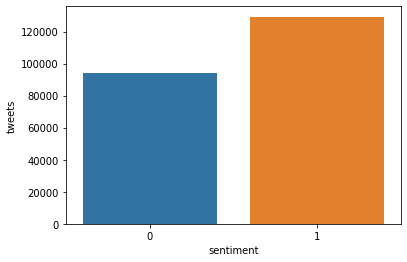

In [92]:
# ===== Data Distribution =====
print(df.groupby('sentiment').count())
print(df.groupby('flag').count())
sn.countplot(x='sentiment', data=df)
plt.ylabel('tweets')

We can see that the classes are approximately balanced, so we won’t perform any undersampling or oversampling method. However, we will anyway use F1 score to evaluate model performance.

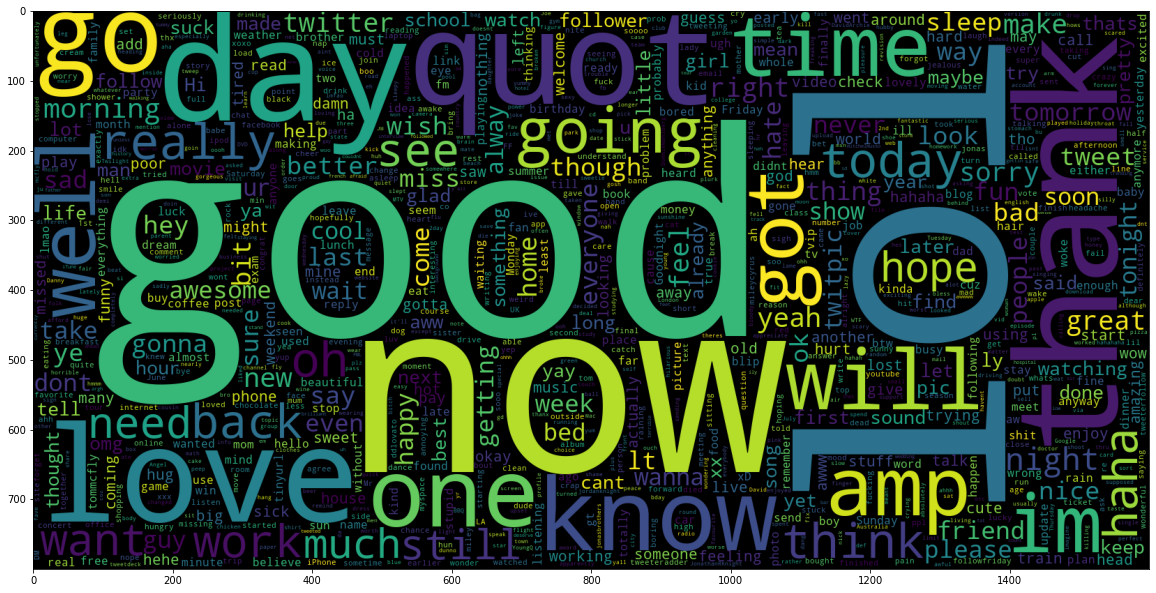

In [ ]:
# ===== Most Frequent Words Analysing =====
words = df['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(words))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [24]:
# ===== keeping only relevant data =====
data = df[['sentiment', 'text']]
data.head()

,sentiment,text
0,1,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,@PleaseBeMine Something for your iphone
3,0,@GabrielSaporta couldn't get in to the after p...
4,0,@bradiewebbstack awww is andy being mean again...


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224994 entries, 0 to 224993
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  224994 non-null  int64 
 1   text       224994 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [26]:
# ===== most frequent words =====
freq_words =  pd.Series(' '.join(data['text']).split()).value_counts()[:15]
fwords = freq_words.index.tolist()
fwords

['I',
 'to',
 'the',
 'a',
 'you',
 'i',
 'and',
 'my',
 'it',
 'for',
 'is',
 'in',
 'of',
 'on',
 'have']

**2. Feature Engineering and Preprocessing**

When dealing with text data, there are several ways of obtaining features that represent the data. We will use the most common method named Term-Frequency Inverse-Document-Frequency and applying some useful functions to clean our texts while the generalization is satisfied. 

***2-1. Text Cleaning***

Before creating any feature from the raw text, we must perform a cleaning process to ensure no distortions are introduced to the model.

In [27]:
# ===== Removing Duplicates =====
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
for column in df.columns:
    print(f"Number of unique {column}: {df[column].nunique()}")

Number of unique sentiment: 2
Number of unique ids: 223106
Number of unique date: 188654
Number of unique flag: 1
Number of unique user: 10646
Number of unique text: 223106


In [28]:
# ===== defining useful functions for cleaning text ---> optimal for vectorizing with unigrams and bigrams =====
stop_words = stopwords.words('english')

def remove_words(text, words):
    #tokenize the tweet
    tweet = word_tokenize(text)
    #removing stopwords
    no_sw_tweet = [word for word in tweet if not word in words]
    #building back the tweet
    text = ' '.join(no_sw_tweet)
    return text

def remove_numbers(text):
    return text.translate(str.maketrans('', '', string.digits))

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_urls(text):
    return re.sub(r"http\S+", "", text)

def remove_usernames(text):
    return re.sub("@[^\s]+", "", text)

def remove_emojis(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

def contraction_replace(data):
  return contractions.fix(data)



In [29]:
    # ===== normalizing data =====
data['text'] = data['text'].str.lower()
    # ===== applying changes =====
data['text'] = data['text'].apply(lambda x: remove_emojis(x))
data['text'] = data['text'].apply(lambda x: remove_usernames(x))
data['text'] = data['text'].apply(lambda x: remove_punctuation(x))
data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data['text'] = data['text'].apply(lambda x: remove_urls(x))
data['text'] = data['text'].apply(lambda x: remove_words(x, fwords))
data['text'] = data['text'].apply(lambda x: contraction_replace(x))

data.head()

,sentiment,text
0,1,yes talking helps lot going through there is n...
1,1,sunshine livingg itttt imma lie grass listenin...
2,1,something your iphone
3,0,could not get after party
4,0,awww andy being mean again now want maccas


Since stemming showed better result, at this step we use stemming instead of lemmetazation to produce output words.  

In [30]:
# ===== applying stemming =====
st = SnowballStemmer(language='english')
data['text'] = data['text'].apply(lambda x: [st.stem(y) for y in x.split(' ')])
data['text'] = data['text'].apply(lambda x: ' '.join(x))
data.head()

,sentiment,text
0,1,yes talk help lot go through there is no judgm...
1,1,sunshin livingg itttt imma lie grass listen oa...
2,1,someth your iphon
3,0,could not get after parti
4,0,awww andi be mean again now want macca


***2-2. Train-Test Split***

We'll set apart a test set to prove the quality of our models. We'll do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.

In [31]:
# ===== train_test_split =====
X = data['text']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((202494,), (22500,))

To keep generalization and be unbiased and according to the size of the dataset plus using cross validation, we can set the test size equal to 0.1  

***2-3. Text Representation***

Considering the number distinct words in our dataset which is about 650,000, in order to obtain a fair maximum number for features, we use learning curve to find the knee point to avoid producing some issues such as overfitting. 

Fitting data for iteration: 0
F1 score for iteration 0 corresponding to 1000 features is 0.7573914906560757

Fitting data for iteration: 1
F1 score for iteration 1 corresponding to 2000 features is 0.7678835872652019

Fitting data for iteration: 2
F1 score for iteration 2 corresponding to 3000 features is 0.7719121536020425

Fitting data for iteration: 3
F1 score for iteration 3 corresponding to 4000 features is 0.774879869191148

Fitting data for iteration: 4
F1 score for iteration 4 corresponding to 5000 features is 0.7751568315003055

Fitting data for iteration: 5
F1 score for iteration 5 corresponding to 6000 features is 0.7757994460289477

Fitting data for iteration: 6
F1 score for iteration 6 corresponding to 7000 features is 0.7784374129152264

Fitting data for iteration: 7
F1 score for iteration 7 corresponding to 8000 features is 0.7782794102857649

Fitting data for iteration: 8
F1 score for iteration 8 corresponding to 9000 features is 0.7792340846303989

Fitting data for ite

Text(0, 0.5, 'F1 scores')

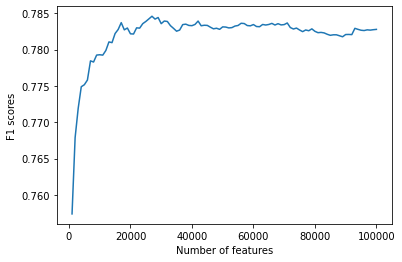

In [ ]:
# ===== computing the best f1 score for the model in order to work in the correct range =====
fn = [x for x in range(1000, 100001, 1000)]
fscores = list()
count = 0

for feature_number in fn:
    vect = TfidfVectorizer(binary=True, max_features=feature_number, sublinear_tf=True, ngram_range=(1, 2))
    X_train_f = vect.fit_transform(X_train)
    X_test_f = vect.transform(X_test)
    clf = LinearSVC(C=0.1, class_weight='balanced', dual=False, random_state=0, tol=1e-05)
    print(f"Fitting data for iteration: {count}")
    clf.fit(X_train_f[:50000], y_train[:50000])
    y_pred = clf.predict(X_test_f[:50000])
    f = f1_score(y_pred[:50000], y_test[:50000], average='macro')
    print(f"F1 score for iteration {count} corresponding to {feature_number} features is {f}")
    fscores.append(f)
    print("==============================================" + '\n')
    count = count + 1
  
plt.plot(np.array(fn), fscores)
plt.xlabel('Number of features')
plt.ylabel('F1 scores')

So we apply max feature equal to 85000.

In [32]:
# ===== tfidf vectorization =====
tfidf = TfidfVectorizer(binary=False, sublinear_tf=True, max_features=85000, ngram_range= (1, 2))
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

X_train.shape, type(X_train)

((202494, 85000), scipy.sparse.csr.csr_matrix)

***3. Model Learning and Hyperparameter Tuning***

There are four classifier models named K-Nearest Neighbors, Random Forest, Logistic Regression and Linear SVM. It should be mentioned that due to the poor PC configuration and some time-consuming model like RFC, all running processes have been performed on Google Colab. Besides, it should also be noticed according to space and time limitation of Colab platform, we perform hyperparameters tuning of each model with truncated dataset separately. Therefore, in this file, we put most important parameters for tuning to show the procedure and some fixed parameters which have been tuned in separate files. Although, we explain for each specific model, the entire parameters which have great effect on our dataset and the combinations of them are allowed.

***3-1. Model Definition***

In [42]:
models = [
    KNeighborsClassifier(),
    LogisticRegression(),
    RandomForestClassifier(),
    LinearSVC(),
]

***3-2. Hyperparamers Tuning***

For this porpuse, we apply Grid Search with kfold equals to five for all models.

In [54]:
# ===== knn hyperparamter tuning =====
knn_param_grid = {
    'n_neighbors' : [1, 2, 3],
    'p' : [1, 2]
}

# Instantiate the grid search model
knn_grid = GridSearchCV(models[0], knn_param_grid, cv=5, verbose=2)

# Fit the grid search to the data
knn_grid.fit(X_train[0:50000, :], y_train[0:50000])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .................................n_neighbors=1, p=1; total time=  46.2s
[CV] END .................................n_neighbors=1, p=1; total time=  42.4s
[CV] END .................................n_neighbors=1, p=1; total time=  42.4s
[CV] END .................................n_neighbors=1, p=1; total time=  42.2s
[CV] END .................................n_neighbors=1, p=1; total time=  42.2s
[CV] END .................................n_neighbors=1, p=2; total time=   6.2s
[CV] END .................................n_neighbors=1, p=2; total time=   6.1s
[CV] END .................................n_neighbors=1, p=2; total time=   6.1s
[CV] END .................................n_neighbors=1, p=2; total time=   6.1s
[CV] END .................................n_neighbors=1, p=2; total time=   6.1s
[CV] END .................................n_neighbors=2, p=1; total time=  42.9s
[CV] END .................................n_neigh

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3], 'p': [1, 2]}, verbose=2)

In [55]:
print("The best hyperparameters from Grid Search are:")
print(knn_grid.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(knn_grid.best_score_)

best_knn = knn_grid.best_estimator_
print(best_knn)
best_knn.fit(X_train, y_train)
knn_pred = best_knn.predict(X_test)

# =============Test accuracy=============
print("The test accuracy is: ")
print(f1_score(y_test, knn_pred, average='macro'))

The best hyperparameters from Grid Search are:
{'n_neighbors': 1, 'p': 2}

The mean accuracy of a model with these hyperparameters is:
0.59056
KNeighborsClassifier(n_neighbors=1)
The test accuracy is: 
0.5354279984402497


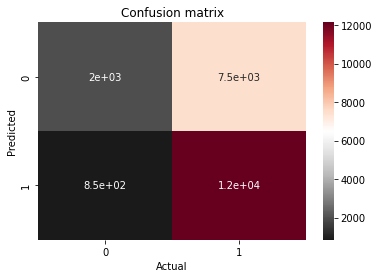

In [ ]:
# =============Confusion Matrix=============
conf_matrix = confusion_matrix(y_test, knn_pred)
sn.heatmap(conf_matrix, 
            annot=True,
            cmap="RdGy_r")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [50]:
# ===== Logistic Regression random forest classifier hyperparameter tuning =====
lr_param_grid = {
    
    'penalty':['l2'],
    'dual': [False],
    'tol':[1e-3, 1e-4, 1e-5, 1e-6],
    'C': [1e-3, 1e-1, 1, 2],
    'fit_intercept':[True],
    'class_weight':['balanced'],
    'random_state':[0, 8],
    'solver':['lbfgs', 'sag']
}
# Instantiate the grid search model
lr_grid = GridSearchCV(models[1], lr_param_grid, cv=5, verbose=2)

# Fit the grid search to the data
lr_grid.fit(X_train[0:50000, :], y_train[0:50000])

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END C=0.001, class_weight=balanced, dual=False, fit_intercept=True, penalty=l2, random_state=0, solver=lbfgs, tol=0.001; total time=   0.3s
[CV] END C=0.001, class_weight=balanced, dual=False, fit_intercept=True, penalty=l2, random_state=0, solver=lbfgs, tol=0.001; total time=   0.2s
[CV] END C=0.001, class_weight=balanced, dual=False, fit_intercept=True, penalty=l2, random_state=0, solver=lbfgs, tol=0.001; total time=   0.3s
[CV] END C=0.001, class_weight=balanced, dual=False, fit_intercept=True, penalty=l2, random_state=0, solver=lbfgs, tol=0.001; total time=   0.3s
[CV] END C=0.001, class_weight=balanced, dual=False, fit_intercept=True, penalty=l2, random_state=0, solver=lbfgs, tol=0.001; total time=   0.3s
[CV] END C=0.001, class_weight=balanced, dual=False, fit_intercept=True, penalty=l2, random_state=0, solver=lbfgs, tol=0.0001; total time=   0.3s
[CV] END C=0.001, class_weight=balanced, dual=False, fit_intercept=

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.1, 1, 2], 'class_weight': ['balanced'],
                         'dual': [False], 'fit_intercept': [True],
                         'penalty': ['l2'], 'random_state': [0, 8],
                         'solver': ['lbfgs', 'sag'],
                         'tol': [0.001, 0.0001, 1e-05, 1e-06]},
             verbose=2)

In [56]:
print("The best hyperparameters from Grid Search are:")
print(lr_grid.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(lr_grid.best_score_)

best_lr = lr_grid.best_estimator_
print(best_lr)
best_lr.fit(X_train, y_train)
lr_pred = best_lr.predict(X_test)

# =============Test accuracy=============
print("The test accuracy is: ")
print(f1_score(y_test, lr_pred, average='macro'))

The best hyperparameters from Grid Search are:
{'C': 2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.001}

The mean accuracy of a model with these hyperparameters is:
0.7813800000000001
LogisticRegression(C=2, class_weight='balanced', random_state=0, tol=0.001)
The test accuracy is: 
0.7990267084883298


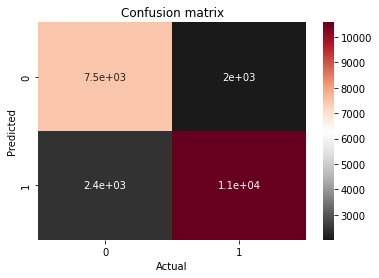

In [ ]:
# =============Confusion Matrix=============
conf_matrix = confusion_matrix(y_test, lr_pred)
sn.heatmap(conf_matrix, 
            annot=True,
            cmap="RdGy_r")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [43]:
# ===== random forest classifier hyperparameter tuning =====
rfc_param_grid = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators': [400],
    'max_depth' : [5, 10, 100],
    'max_features' : ['sqrt', 'log2']
}

# Instantiate the grid search model
rfc_grid = GridSearchCV(models[2], rfc_param_grid, cv=5, verbose=2)

# Fit the grid search to the data
rfc_grid.fit(X_train[0:50000], y_train[0:50000])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=400; total time=  12.2s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=400; total time=  12.2s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=400; total time=  12.1s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=400; total time=  12.1s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=400; total time=  12.1s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=400; total time=   6.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=400; total time=   6.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=400; total time=   5.9s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=400; total time=   5.9s
[CV] END criterion=gini, max_depth=5, max_features=log2, n_estimators=400; total time=   6.0s

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 100],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [400]},
             verbose=2)

In [47]:
print("The best hyperparameters from Grid Search are:")
print(rfc_grid.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(rfc_grid.best_score_)

best_rfc = rfc_grid.best_estimator_
print(best_rfc)
best_rfc.fit(X_train, y_train)
rfc_pred = best_rfc.predict(X_test)

# =============Test accuracy=============
print("The test accuracy is: ")
print(f1_score(y_test, rfc_pred, average='macro'))

The best hyperparameters from Grid Search are:
{'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 400}

The mean accuracy of a model with these hyperparameters is:
0.73418
RandomForestClassifier(max_depth=100, max_features='sqrt', n_estimators=400)
The test accuracy is: 
0.7144414800759122


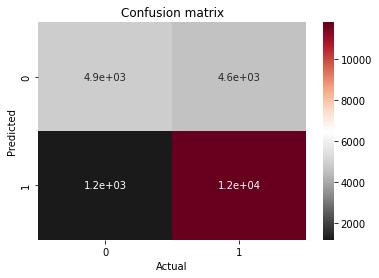

In [48]:
# =============Confusion Matrix=============
conf_matrix = confusion_matrix(y_test, rfc_pred)
sn.heatmap(conf_matrix, 
            annot=True,
            cmap="RdGy_r")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [51]:
# ===== linear support vector machine classifier hyperparameter tuning =====
lsvc_param_grid = {
    'penalty':['l2'],
    'loss':['squared_hinge', 'hinge'],
    'tol':[1e-4, 1e-5, 1e-6],
    'C': [1e-5, 1e-3, 1e-1, 1],
    'fit_intercept':[True, False],
    'dual': [False],
    'random_state':[0, 8],
    'class_weight':['balanced']
}

# Instantiate the grid search model
lsvc_grid = GridSearchCV(models[3], lsvc_param_grid, cv=5, verbose=2, scoring='f1_macro')

# Fit the grid search to the data
lsvc_grid.fit(X_train[0:50000, :], y_train[0:50000])

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END C=1e-05, class_weight=balanced, dual=False, fit_intercept=True, loss=squared_hinge, penalty=l2, random_state=0, tol=0.0001; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, dual=False, fit_intercept=True, loss=squared_hinge, penalty=l2, random_state=0, tol=0.0001; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, dual=False, fit_intercept=True, loss=squared_hinge, penalty=l2, random_state=0, tol=0.0001; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, dual=False, fit_intercept=True, loss=squared_hinge, penalty=l2, random_state=0, tol=0.0001; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, dual=False, fit_intercept=True, loss=squared_hinge, penalty=l2, random_state=0, tol=0.0001; total time=   0.1s
[CV] END C=1e-05, class_weight=balanced, dual=False, fit_intercept=True, loss=squared_hinge, penalty=l2, random_state=0, tol=1e-05; total time=   0.1s
[CV] END C=1e-05, class_wei

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1],
                         'class_weight': ['balanced'], 'dual': [False],
                         'fit_intercept': [True, False],
                         'loss': ['squared_hinge', 'hinge'], 'penalty': ['l2'],
                         'random_state': [0, 8],
                         'tol': [0.0001, 1e-05, 1e-06]},
             scoring='f1_macro', verbose=2)

In [52]:
print("The best hyperparameters from Grid Search are:")
print(lsvc_grid.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(lsvc_grid.best_score_)

best_lsvc = lsvc_grid.best_estimator_
print(best_lsvc)
best_lsvc.fit(X_train, y_train)
lsvc_pred = best_lsvc.predict(X_test)

# =============Test accuracy=============
print("The test accuracy is: ")
print(f1_score(y_test, lsvc_pred, average='macro'))

The best hyperparameters from Grid Search are:
{'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'loss': 'squared_hinge', 'penalty': 'l2', 'random_state': 0, 'tol': 0.0001}

The mean accuracy of a model with these hyperparameters is:
0.7755914640496068
The test accuracy is: 
0.8001450072083428


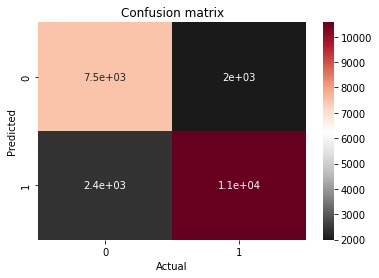

In [53]:
# =============Confusion Matrix=============
conf_matrix = confusion_matrix(y_test, lsvc_pred)
sn.heatmap(conf_matrix, 
            annot=True,
            cmap="RdGy_r")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

***3-3. Best Model Selection and ROC_AUC***

In [57]:
opt_models = [
    best_knn,
    best_lr,
    best_rfc,
    best_lsvc
]

names = [
    'KNN',
    'Logistic Regression',
    'Random Forest Classifier',
    'Linear Support Vector Machine Classifier'
]

roc_curve_fpr = dict()
roc_curve_tpr = dict()
predictions = dict()
roc_auc_scores = dict()

for model, name in zip(opt_models, names):
    print(f"Using model: {name}")
    print("Fitting data...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Computing scores for model {name}...")
    p, r, f1, s = precision_recall_fscore_support(y_test, y_pred, average='macro')
    print(f"Computed F1 score for model {name} is: " + str(f1))
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    print(f"ROC_AUC score for {name} is: {roc_auc_score(y_test, y_pred)}")
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_curve_fpr[name] = fpr
    roc_curve_tpr[name] = tpr
    predictions[name] = y_pred
    #roc_auc_scores[name] = 
    print("===========================================================================" + '\n')

Using model: KNN
Fitting data...
Computing scores for model KNN...
Computed F1 score for model KNN is: 0.5354279984402497
ROC_AUC score for KNN is: 0.5735275884771995

Using model: Logistic Regression
Fitting data...
Computing scores for model Logistic Regression...
Computed F1 score for model Logistic Regression is: 0.7990267084883298
ROC_AUC score for Logistic Regression is: 0.8007932008538132

Using model: Random Forest Classifier
Fitting data...
Computing scores for model Random Forest Classifier...
Computed F1 score for model Random Forest Classifier is: 0.7162639391218415
ROC_AUC score for Random Forest Classifier is: 0.7124984672063024

Using model: Linear Support Vector Machine Classifier
Fitting data...
Computing scores for model Linear Support Vector Machine Classifier...
Computed F1 score for model Linear Support Vector Machine Classifier is: 0.8001450072083428
ROC_AUC score for Linear Support Vector Machine Classifier is: 0.8020592781262391



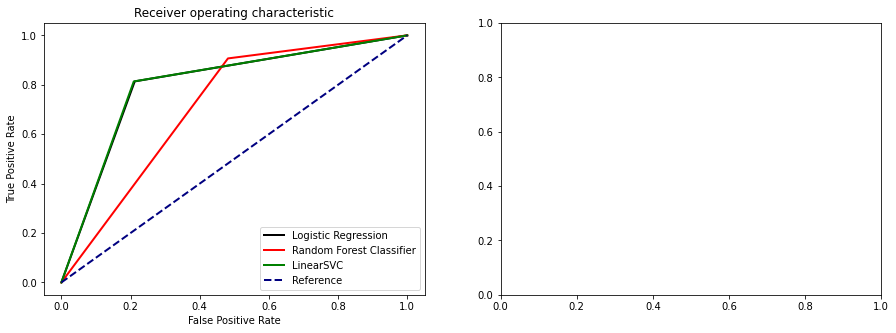

In [87]:
# ===== plotting ROC-AUC curve and confusion matrix for best performing model (LinearSVC())=====
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # ===== roc curve setup =====
lw = 2
ax[0].plot(roc_curve_fpr[names[1]], roc_curve_tpr[names[1]], color="black", lw=lw, label="Logistic Regression")
ax[0].plot(roc_curve_fpr[names[2]], roc_curve_tpr[names[2]], color="red", lw=lw, label="Random Forest Classifier")
ax[0].plot(roc_curve_fpr[names[3]], roc_curve_tpr[names[3]], color="green", lw=lw, label="LinearSVC")
ax[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", label='Reference')
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Receiver operating characteristic")
ax[0].legend(loc="lower right")

In [93]:
# =============Selected Model=============
print('Best model with tuned hyperparameters is:')
print(best_lsvc)

Best model with tuned hyperparameters is:
LinearSVC(C=0.1, class_weight='balanced', dual=False, random_state=0)


In [65]:
# =============Classification Report=============
print("Classification report of best model")
print(classification_report(y_test,lsvc_pred))

Classification report of best model
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      9507
           1       0.84      0.81      0.83     12993

    accuracy                           0.80     22500
   macro avg       0.80      0.80      0.80     22500
weighted avg       0.81      0.80      0.80     22500



***4. Prediction of Evaluation Dataset By Best Model***

In [66]:
# ===== building final submission =====
df_eval = pd.read_csv('evaluation.csv')
data_eval = df_eval['text']

# ===== applying preprocessing =====
data_eval = data_eval.str.lower()
data_eval = data_eval.apply(lambda x: remove_emojis(x))
data_eval = data_eval.apply(lambda x: remove_usernames(x))
data_eval = data_eval.apply(lambda x: remove_punctuation(x))
data_eval = data_eval.apply(lambda x: remove_numbers(x))
data_eval = data_eval.apply(lambda x: remove_urls(x))
data_eval = data_eval.apply(lambda x: remove_words(x, fwords))
data_eval = data_eval.apply(lambda x: contraction_replace(x))

data_eval = data_eval.apply(lambda x: [st.stem(y) for y in x.split(' ')])
data_eval = data_eval.apply(lambda x: ' '.join(x))

X_eval = tfidf.transform(data_eval)

y_pred_eval = best_lsvc.predict(X_eval)

index = [x for x in range(len(y_pred_eval))]
result = pd.DataFrame({'Id':index, 'Predicted':y_pred_eval})
result.to_csv('evaluation_pred.csv', index=False, sep=',')